# Full-disk synthesis

### Load atmosphere from PSI's MAS MHD model

Includes temperature, magnetic field vector, and density distributions in CGS units

In [254]:
import models.MAS.mas as mas
from sunpy.coordinates import sun
import numpy as np
from numba import njit, prange
import sunpy.sun.constants as constants
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
np.seterr(divide='ignore', invalid='ignore')

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

# Setup PSI model
print("Importing coronal model... ", end="")
modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = mas.Model('./models/MAS/corona_cr2194/') #cr2194
print("done")

# Setup observer
print("Initializing observer and image plane... ", end="")
crn= sun.carrington_rotation_number('2017-08-21T12:00:00.000') #2247
crt = sun.carrington_rotation_time(crn)
obsLon = sun.L0(crt).rad
obsLat = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc = sun.angular_radius(crt).value
rObs = Obs_Sun_AU * constants.astronomical_unit.value/constants.radius.value
thetaObs = np.pi / 2 - obsLat
phiObs = obsLon

# Create image
rsunarc = 960
arcsamp = 20.
arc = np.linspace(-3 * rsunarc, 3 * rsunarc, int(6 * rsunarc / arcsamp))
zza, yya = np.meshgrid(arc, arc, indexing='ij')
zza = np.flipud(zza)
mask_ondisk = (np.hypot(zza, yya) > rsunarc).astype(float)

# Project to solar tangent plane
yy = rObs * np.tan(np.deg2rad(yya / 3600.))
zz = rObs * np.tan(np.deg2rad(zza / 3600.))
rr = np.hypot(yy, zz)
xx = np.zeros_like(rr)
xx[rr < 1] = np.sqrt(1 - rr[rr < 1]**2)
print("done")

# Create rays
print("Creating rays through image plane... ", end="")
rot = euler_ry(thetaObs - np.pi/2) @ euler_rz(phiObs)
starts = (rot @ np.stack([xx.ravel(), yy.ravel(), zz.ravel()])).T
obs_vec = rObs * np.array([
    np.sin(thetaObs) * np.cos(phiObs),
    np.sin(thetaObs) * np.sin(phiObs),
    np.cos(thetaObs)
])
los = obs_vec - starts
los /= np.linalg.norm(los, axis=1, keepdims=True)

start_r = 2.0 # start this many solar radii from sun's center
deltaR_forward = corona.rs - start_r
deltaR_forward = deltaR_forward[deltaR_forward >= 0]
deltaR_bidirectional = np.cumsum(np.diff(corona.rs))
deltaR_bidirectional = np.hstack([-deltaR_bidirectional[::-1], deltaR_bidirectional])
deltaR = np.zeros((len(deltaR_bidirectional), starts.shape[0]))
on_disk = np.linalg.norm(starts, axis=1) <= 1.0
deltaR[:len(deltaR_forward), on_disk] = deltaR_forward[:, None]
deltaR[:len(deltaR_bidirectional), ~on_disk] = deltaR_bidirectional[:, None]
rays_xyz = starts[None] + deltaR[:, :, None] * los[None]

# Convert to spherical coordinates
r = np.linalg.norm(rays_xyz, axis=2)
theta = np.arccos(rays_xyz[:, :, 2] / r)
phi = np.mod(np.arctan2(rays_xyz[:, :, 1], rays_xyz[:, :, 0]), 2 * np.pi)
rays_sph = np.stack([phi, theta, r], axis=-1).reshape(-1, 3)
print('done')

# Interpolation
print("Interpolating plasma and magnetic field values... ", end="")
def interp(field, name):
    print(f"({name}) ", end="")
    return rgi(
        (corona.phis, corona.thetas, corona.rs),
        field,
        method='linear',
        fill_value=0.0,
        bounds_error=False
    )(rays_sph).reshape(r.shape)
bx_rays = interp(corona.bx, "bx")
by_rays = interp(corona.by, "by")
bz_rays = interp(corona.bz, "bz")
ne_rays = interp(corona.ne, "density")
temp_rays = interp(corona.temp, "temp")
print("done")

# B-field projections
print("Projecting B-fields along LOS... ", end="")
bvec = np.stack([bx_rays, by_rays, bz_rays], axis=-1)
lvec = rays_xyz / (np.linalg.norm(rays_xyz, axis=2, keepdims=True) + 1e-15)
blos_rays = np.sum(bvec * lvec, axis=2)
btot_rays = np.linalg.norm(bvec, axis=2)
# Step sizes
dray = np.linalg.norm(np.diff(rays_xyz, axis=0), axis=2) * constants.radius.value * 100.  # solar radius in cm
print("done")

Importing coronal model... done
Initializing observer and image plane... done
Creating rays through image plane... done
Interpolating plasma and magnetic field values... (bx) (by) (bz) (density) (temp) done
Projecting B-fields along LOS... done


### Synthesis

In [255]:
import pysolrad

v = 1000e6
rays = pysolrad.RayCollection(temp_rays[:-1], btot_rays[:-1], blos_rays[:-1], ne_rays[:-1], dray, axis=0) # rays can be 2D or 3D - 2D is useful for non-cartesian coordinate systems like polar
img = pysolrad.synthesize(rays, v, dogyro=False).reshape(*yya.shape) # since we only had 2D array of rays, we need to reshape the resulting image

[⎯] - creating rays... 5/5 quantities - done
[⎯] - synthesizing... - done


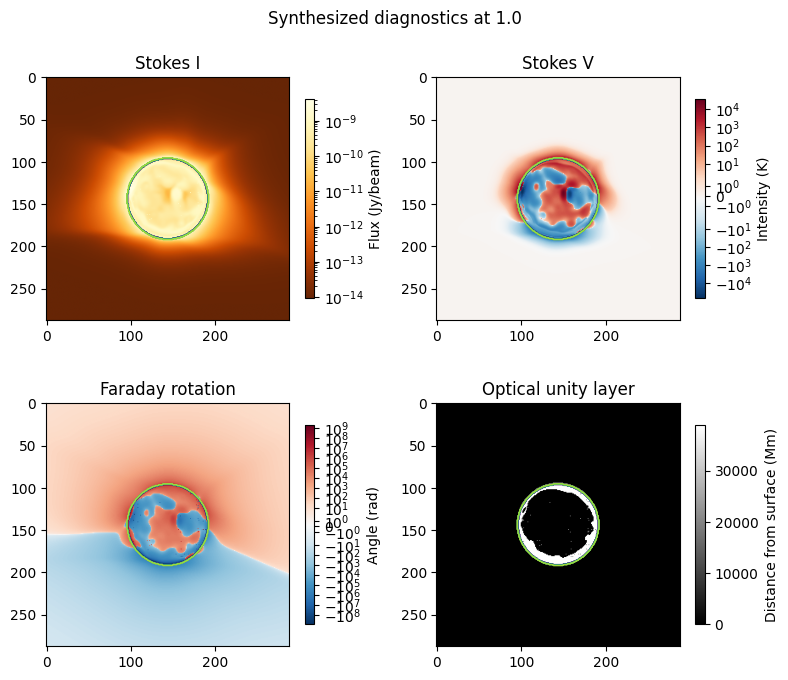

In [256]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
im0 = axs[0, 0].imshow(img.I.to('Jy/beam'), cmap='YlOrBr_r', norm='log')
axs[0, 0].set_title('Stokes I')
fig.colorbar(im0, ax=axs[0, 0], label='Flux (Jy/beam)', shrink=0.7)
axs[0, 0].contour(mask_ondisk, linewidths=1)
im1 = axs[0, 1].imshow(img.V, cmap='RdBu_r', norm='symlog')
axs[0, 1].set_title('Stokes V')
fig.colorbar(im1, ax=axs[0, 1], label='Intensity (K)', shrink=0.7)
axs[0, 1].contour(mask_ondisk, linewidths=1)
im2 = axs[1, 0].imshow(img.faraday, cmap='RdBu_r', norm='symlog')
axs[1, 0].set_title('Faraday rotation')
fig.colorbar(im2, ax=axs[1, 0], label='Angle (rad)', shrink=0.7)
axs[1, 0].contour(mask_ondisk, linewidths=1)
im3 = axs[1, 1].imshow(img.unity.to('Mm'), cmap='gray')
axs[1, 1].set_title('Optical unity layer')
fig.colorbar(im3, ax=axs[1, 1], label='Distance from surface (Mm)', shrink=0.7)
axs[1, 1].contour(mask_ondisk, linewidths=1)
plt.suptitle(f'Synthesized diagnostics at {str(pysolrad.Quantity(img.v, 'Hz').to('GHz'))}')
plt.tight_layout()
plt.show()

### 2D magnetic field inversion

$P=n\frac{2.8\times 10^6}{v}B_{\text{los}}$ where spectral index $n\equiv -\frac{\partial{\log T_b}}{\partial{\log v}}$ and $P=\frac{V}{I}$

from Chapter 6 of [Solar and Space Weather Radio Physics](https://drive.google.com/file/d/1nPEj6RIKA_eOtnwODCnCgedhT0LWunM2/view)

In [260]:
from importlib import reload
reload(pysolrad)
freq_range = np.logspace(5, 12, 10) # frequencies to sample
images = pysolrad.synthesize_range(rays, freq_range)
inverted_blos_collection = pysolrad.invert_blos(images)
blos_at_unity_collection = pysolrad.get_quantity_at_unity(rays, 'blos', images)

for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    inverted_blos = inverted_blos_collection[idx]
    blos_at_unity = blos_at_unity_collection[idx]
    im0 = axs[0].imshow(inverted_blos.reshape(*yya.shape), origin='lower', cmap='RdBu_r', vmax=blos_at_unity.max(), vmin=blos_at_unity.min())
    axs[0].set_title(f"Inverted BLOS")
    fig.colorbar(im0, ax=axs[0], shrink=0.8)
    axs[0].contour(mask_ondisk, linewidths=1)
    im1 = axs[1].imshow(blos_at_unity.reshape(*yya.shape), origin='lower', cmap='RdBu_r')
    axs[1].set_title(f"Emissivity-weighted BLOS")
    axs[1].contour(mask_ondisk, linewidths=1)
    fig.colorbar(im1, ax=axs[1], shrink=0.8)
    im2 = axs[2].imshow(blos_at_unity.right.reshape(*yya.shape), origin='lower', cmap='RdBu_r')
    axs[2].set_title(f"BLOS at right unity layer")
    axs[2].contour(mask_ondisk, linewidths=1)
    fig.colorbar(im2, ax=axs[2], shrink=0.8)
    im3 = axs[3].imshow(blos_at_unity.left.reshape(*yya.shape), origin='lower', cmap='RdBu_r')
    axs[3].set_title(f"BLOS at left unity layer")
    axs[3].contour(mask_ondisk, linewidths=1)
    fig.colorbar(im3, ax=axs[3], shrink=0.8)
    plt.suptitle(f"Inversion @ {str(pysolrad.Quantity(images.v[idx], 'Hz').to('MHz'))}")
    plt.tight_layout()
    plt.show()

SyntaxError: invalid syntax (pysolrad.py, line 751)